# Notebook to explore the universe of alternative alphabets

Goal is to write a poem that will allow complementary base pairing: i.e. the key and query of a dictionary can be flipped and still allow for a valid sentence.

In [1]:
import numpy as np
import pandas as pd
import string
import os
import shutil
import plotnine
from plotnine import *
from timeit import timeit
import string
from time import time

from math import factorial
import itertools

import importlib
import funs
importlib.reload(funs)
from funs import makeifnot
from funs import rand_mapping, alpha_trans, get_cipher, npair_max

import nltk
from nltk.tokenize import word_tokenize
import contextlib, io

def capture(fun,arg):
    f = io.StringIO()
    with contextlib.redirect_stdout(f):
        fun(arg)
    output = f.getvalue()
    return output


letters = [l for l in string.ascii_lowercase]

In [2]:
# There are >51 billion possible alphabet encodings
print(f"{np.prod(np.arange(2,27,2)):,}")

51,011,754,393,600


In [3]:
# print(f"{:,}")
# np.prod(np.arange(1,27,1))

### (1) Download datasets

In [4]:
dir_code = os.getcwd()
dir_data = os.path.join(dir_code, '..', 'data')
makeifnot(dir_data)
# (1) Download the ngrams data for frequency
path_ngram = os.path.join(dir_data,'words_ngram.txt')
if not os.path.exists(path_ngram):
    !wget -q -O ../data/words_ngram.txt https://norvig.com/ngrams/count_1w.txt
else:
    print('words_ngram.txt already exists')

# (2) Download the curated dataset
path_words = os.path.join(dir_data,'words_corncob.txt')
if not os.path.exists(path_words):
    print('Downloading')
    !wget -q -O ../data/words_corncob.txt http://www.mieliestronk.com/corncob_lowercase.txt
else:
    print('corncob_lowercase.txt already exists')
#https://github.com/dwyl/english-words

words_ngram.txt already exists
corncob_lowercase.txt already exists


## (2) Load datasets

In [5]:
# (1) Load the Ngrams
df_ngram = pd.read_csv(path_ngram,sep='\t',header=None).rename(columns={0:'word',1:'n'})
df_ngram = df_ngram[~df_ngram.word.isnull()].reset_index(None, True)

# (2) Load the short word set
df_words = pd.read_csv(path_words,sep='\n',header=None).rename(columns={0:'word'})
df_words = df_words[~df_words.word.isnull()].reset_index(None, True)

# Overlap?
n_overlap = df_words.word.isin(df_ngram.word).sum()
print('A total of %i short words overlap (out of %i)' % 
     (n_overlap, df_words.shape[0]))

# Merge datasets in the intersection
df_merge = df_ngram.merge(df_words,'inner','word')
df_merge = df_merge.assign(n_sqrt=lambda x: np.sqrt(x.n), n_log=lambda x: np.log(x.n))

# Examine the score frequency by percentiles
p_seq = np.arange(0.01,1,0.01)
dat_n_q = df_merge.melt('word',None,'tt').groupby('tt').value.quantile(p_seq).reset_index()
dat_n_q.rename(columns={'level_1':'qq'}, inplace=True)
dat_n_q.tt = pd.Categorical(dat_n_q.tt,['n','n_sqrt','n_log'])
di_tt = {'n':'n', 'n_sqrt':'sqrt','n_log':'log'}

A total of 51886 short words overlap (out of 58109)


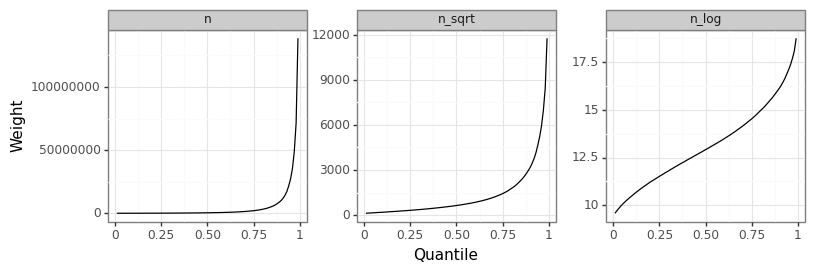

<ggplot: (8732746564825)>

In [6]:
# DISTIRUBTION OF WORD FREQUENCIES
plotnine.options.figure_size = (9, 2.5)
gg_q = (ggplot(dat_n_q, aes(x='qq',y='value')) + geom_path() + 
       theme_bw() + facet_wrap('~tt',scales='free_y') + 
       labs(y='Weight', x='Quantile') + 
       theme(subplots_adjust={'wspace': 0.25}))
gg_q

In [7]:
print('The ten most and least common words in the corpus')
pd.concat([df_merge.head(10)[['word','n']].reset_index(None,True),
           df_merge.tail(10)[['word','n']].reset_index(None,True)],1)

The ten most and least common words in the corpus


,word,n,word,n
0,the,23135851162,offcuts,12748
1,of,13151942776,hinderer,12737
2,and,12997637966,eminences,12734
3,to,12136980858,vaporisation,12732
4,in,8469404971,expurgated,12732
5,for,5933321709,concussed,12732
6,is,4705743816,griever,12729
7,on,3750423199,sibilance,12720
8,that,3400031103,synchronises,12719
9,by,3350048871,insatiably,12717


In [8]:
letter_freq = df_merge[['word','n']].apply(lambda x: list(x.word),1).reset_index().explode(0)
letter_freq.rename(columns={0:'letter','index':'idx'}, inplace=True)
letter_freq_n = letter_freq.merge(df_merge.rename_axis('idx').n.reset_index()).groupby('letter').n.sum().reset_index()
letter_freq_n = letter_freq_n.sort_values('n',ascending=False).reset_index(None,True)
letter_freq_n.head()

,letter,n
0,e,312191856406
1,t,225437874527
2,o,201398083835
3,a,198476530159
4,i,192368122407


### (3) Create mappings

In [9]:
# Example of random mapping
num_letters = np.arange(1,27)
di_num2let = dict(zip(num_letters, letters))
nletters = 26
Xmap = rand_mapping(1,letters, nletters)
di_map = dict(zip(Xmap[:,0], Xmap[:,1]))
rwords = df_merge.word.sample(3,random_state=1)
print(pd.DataFrame({'words':rwords, 'mapped':alpha_trans(rwords, Xmap).values}))
print('Mapping: %s' % (','.join(pd.DataFrame(Xmap).apply(lambda x: x.str.cat(sep=':'),1).to_list())))

         words   mapped
43284  scarcer  neqdecd
7314   adaptor  qrqzuhd
7460   distant  rmnuqsu
Mapping: s:n,r:d,w:k,t:u,e:c,v:g,o:h,x:b,q:a,p:z,y:j,i:m,l:f


In [10]:
# Show that our letter pairings are unique
for j in range(2, 13, 2):
    alphabet = letters[0:j]
    jalphabet = ''.join(alphabet)
    mx_perm = npair_max(alphabet)
    print('The first %i letters has %i mappings' % (j, mx_perm))
    malphabet = pd.Series(np.array([alpha_trans([jalphabet],get_cipher(i, alphabet)) for i in range(mx_perm)]).flat)
    assert not malphabet.duplicated().any()

The first 2 letters has 1 mappings
The first 4 letters has 3 mappings
The first 6 letters has 15 mappings
The first 8 letters has 105 mappings
The first 10 letters has 945 mappings
The first 12 letters has 10395 mappings


### (4) Exhaustive mapping for "top" 12 letters

In [11]:
alphabet12 = letter_freq_n.letter[0:12].to_list()
jalphabet12 = ''.join(alphabet12)
words12 = df_merge.word[~df_merge.word.str.contains('[^'+jalphabet12+']')].to_list()
print('There are %i unique words using the top 12 letters' % (len(words12)))

There are 6532 unique words using the top 12 letters


In [ ]:
mx_perm12 = npair_max(alphabet12)
holder = np.zeros(mx_perm12,dtype=int)
stime, ncheck = time(), 1000
for i in range(mx_perm12):
    xmap_i = get_cipher(i, alphabet12)
    npair_i = alpha_trans(words12,xmap_i).isin(words12).sum()
    holder[i] = npair_i
    if (i + 1) % ncheck == 0:
        nleft, nrun, dtime = mx_perm12 - (i+1), i + 1, time() - stime
        rate = nrun / dtime
        eta = nleft / rate
        print('%0.1f calculations per second. ETA: %i seconds for %i remaining' % 
              (rate, eta, nleft))
dat12 = pd.DataFrame({'idx':range(mx_perm12),'n':holder}).sort_values('n',ascending=False).reset_index(None,True)
xmap12 = get_cipher(dat12.idx[0], alphabet12)

In [45]:
# Function that takes a word list, cipher, and returns word pairings with word types
# corpus: some vector of strings
# cipher: numpy kx2 cipher array
# PoS: parts of speech lookup
def annot_vocab_cipher(corpus, cipher, PoS):
    assert isinstance(cipher, np.ndarray)
    if not isinstance(corpus,pd.Series):
        corpus = pd.Series(corpus.copy())
    tcorpus = alpha_trans(corpus, cipher)
    idx = corpus.isin(tcorpus)
    corpus, tcorpus = corpus[idx], tcorpus[idx]
    df = pd.DataFrame({'w1':corpus,'w2':tcorpus}).reset_index(None,True)
    return df

mapper12 = annot_vocab_cipher(words12, xmap12)
mapper12.head()

,w1,w2
0,is,at
1,this,scat
2,it,as
3,at,is
4,as,it


In [59]:
nltk.pos_tag(mapper12.w1.head().to_list())

[('is', 'VBZ'), ('this', 'DT'), ('it', 'PRP'), ('at', 'IN'), ('as', 'IN')]

In [55]:
# # Get the different Parts-of-Speech values: USE DF_MERGE
capture(nltk.help.upenn_tagset,'PRP$').split(', ')[0].split(': ')

['PRP$', 'pronoun']

## Thinking about the Shiny App

1. Let users pick a number from 1 to 56 billion, or a "top" number
2. Let users pick which letters they want in the alphabet (a,b,c,d,e,f for example)
3. Users type in the left box, translation happens in the right
4. Enable auto-complete with GPT-2 or some such thing
5. Show word list: organized by nouns, verbs, adjectives, etc

In [14]:
# def forwardPerm(idx, lst):
#     alst = lst.copy()  # Active copy
#     holder = []  # Store the list combination and index
#     for j in range(len(lst)):
#         if len(alst) == 1:  # Terminate when there is one element less
#             q = 0
#             v = alst[q]
#             holder.append([v, q])
#             break
#         else:
#             nperm = factorial(len(alst)-1)
#             q, r = divmod(idx, nperm)
#             v = alst[q]
#             alst.remove(v)  # Remove v from the list
#             idx = r
#             holder.append([v, q])
#     return holder


# dat = pd.concat([pd.DataFrame(forwardPerm(i,letters[0:4])).assign(idx=i) for i in range(24)])
# dat.rename(columns={0:'letter', 1:'q'},inplace=True)
# dat.groupby(['letter','q']).size().reset_index().rename(columns={0:'n'})

In [15]:
# txt = words.sample(13,random_state=1).copy()
# trans = alpha_trans(txt, Xmap)
# df_example = pd.concat([pd.DataFrame(Xmap,columns=['from','to']),
#                         pd.DataFrame({'original':txt, 'mapped':trans}).reset_index(None,True)],1)
# print(df_example)  #[['from','to']]

In [16]:
# from time import time

# nsim = 80000
# tnow = time()

# holder = []
# for ii in range(nsim):
#     if (ii+1) % 10000 == 0:
#         tdiff = time() - tnow
#         print('Simulation %i of %i (took %i seconds)' % (ii+1, nsim, tdiff))
#         tnow = time()
#     # Generate a random mapping
#     Xmap = gen_mapping(ii, letters, nletters)
#     words = words[words.notnull()].reset_index(None,True)
#     trans = alpha_trans(words.copy(), Xmap)
#     idx = trans.isin(words)
#     df = pd.DataFrame({'original':words[idx],'mapped':trans[idx],'seed':ii})
#     holder.append(df)
# dat_sim = pd.concat(holder).reset_index(None,True)